In [5]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from ase import *
from ase.io import read
from gpaw import *

from ase.units import Hartree
from gpaw.utilities.dos import LCAODOS, RestartLCAODOS, fold


from gpaw.lcao.pwf2 import LCAOwrap
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, lowdin_rotation
from ase.io import read
from qtpyt.basis import Basis


### Helper functions

In [6]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

def plot_atomic_positions_by_species(atoms, element_colors):
    fig, ax = plt.subplots(figsize=(5, 10))
    positions = atoms.positions
    x = positions[:, 0]
    y = positions[:, 1]

    colors = [element_colors[atom.symbol] for atom in atoms]

    ax.scatter(x, y, color=colors, s=300)

    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.text(xi, yi, str(i), color='black', fontsize=9, ha='center', va='center')


    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_title('Atomic Positions by Species')

    plt.show()

def create_active_hamiltonian(H, S,  index_active_region):
    # Create a list of indices to retain
    indices_to_keep = sorted(list(index_active_region))

    # Create the H_active matrix by extracting the relevant rows and columns
    H_active = H[np.ix_(indices_to_keep, indices_to_keep)]
    S_active = S[np.ix_(indices_to_keep, indices_to_keep)]

    return H_active, S_active


## Visualize structure and how the atoms are ordered

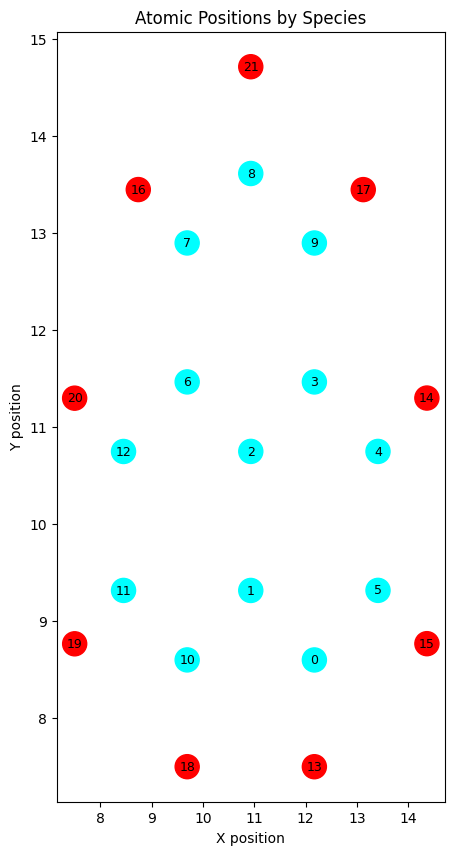

In [7]:
atoms = read('./struct.xyz')
element_colors = {'C':'cyan','H':'red'}

plot_atomic_positions_by_species(atoms, element_colors)

### Check DFT calculations

In [8]:
gpaw_file = 'output/struct.gpw'
calc = GPAW(gpaw_file, txt=None)
dos = RestartLCAODOS(calc)
pdos = LCAODOS(calc)


In [9]:
E_fermi = calc.get_fermi_level()
E_fermi

-3.6576463044768297

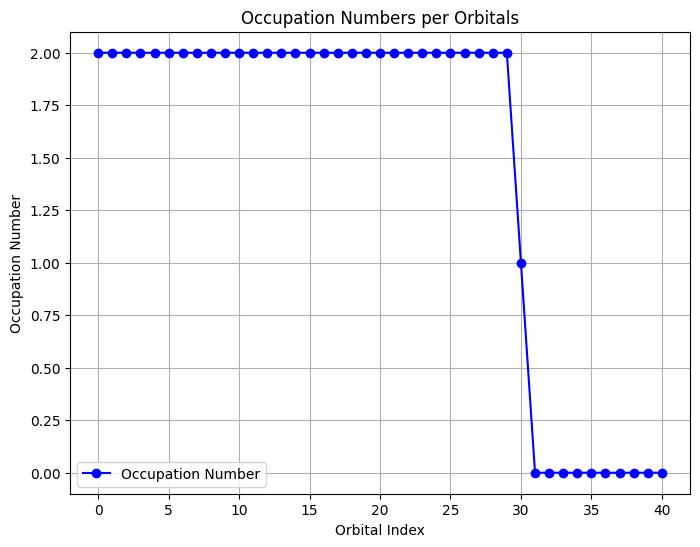

In [10]:
occ = calc.get_occupation_numbers()
# Plot the occupation numbers
plt.figure(figsize=(8, 6))
plt.plot(range(len(occ)), occ, 'bo-', label='Occupation Number')

# Label the plot
plt.title('Occupation Numbers per Orbitals')
plt.xlabel('Orbital Index')
plt.ylabel('Occupation Number')
plt.ylim([-0.1, 2.1])  # Occupation numbers typically range between 0 and 2
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

#### Visualize the states

In [11]:
# Get all eigenvalues
eigenvalues = calc.get_eigenvalues()

homo_energy, lumo_energy = calc.get_homo_lumo()

# Find the band index of HOMO and LUMO by matching with eigenvalues
homo_index = np.where(np.isclose(eigenvalues, homo_energy))[0][0]
lumo_index = np.where(np.isclose(eigenvalues, lumo_energy))[0][0]

print(f"HOMO band index: {homo_index}")
print(f"LUMO band index: {lumo_index}")

HOMO band index: 29
LUMO band index: 30


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


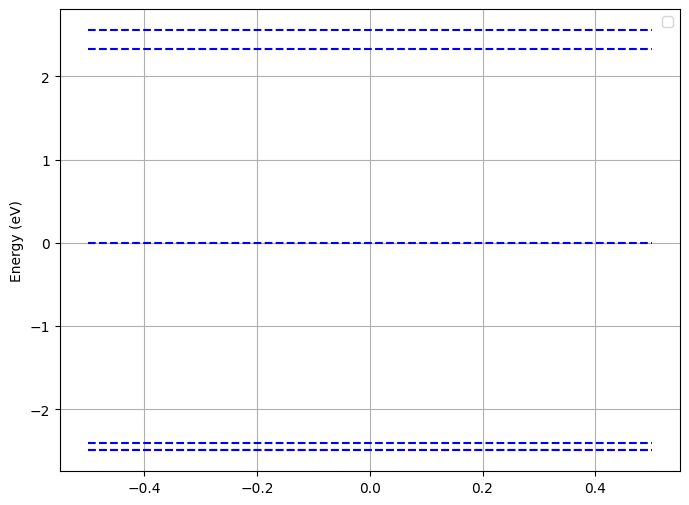

In [12]:
# Define how many states above and below the Fermi level to plot
n_valence = 2
n_conduction = 3

# Select indices for the eigenstates ±n around the Fermi level
start_index = max(homo_index - n_valence, 0)  # Ensure index does not go below zero
end_index = min(lumo_index + n_conduction, len(eigenvalues))  # Ensure index does not go above the total number of eigenstates
selected_indices = np.arange(start_index, end_index)

# Plot the eigenvalues
plt.figure(figsize=(8, 6))
x_min, x_max = -0.5, 0.5

for idx in selected_indices:
    energy = eigenvalues[idx]
    energy -= E_fermi # Move Fermi to 0 eV
    # Plot a horizontal line at each eigenvalue with finite width along x
    plt.hlines(energy, x_min, x_max, colors='blue', linestyles='--')
# plt.axhline(0, color='red', linestyle='--')


plt.ylabel('Energy (eV)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
 # Calculate the HOMO-LUMO gap
homo_lumo_gap = lumo_energy - homo_energy

print(f"HOMO energy: {homo_energy - E_fermi} eV")
print(f"LUMO energy: {lumo_energy -  E_fermi} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

HOMO energy: -2.403139756540456 eV
LUMO energy: 7.100944725557667e-07 eV
HOMO-LUMO gap: 2.4031404666349285 eV


### Get Hamiltonian and Overlap matrices in the LCAO basis

In [14]:
# Since this is a molecule, I've performed a Gamma point calculation and the assumption is the H_gamma is equivalent to a real space Hamiltonian H_R.

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()

# Move Fermi to 0 eV

H_lcao -= E_fermi * S_lcao

Condition number: 3.3e+04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HOMO energy: -2.403139756540461 eV
LUMO energy: 7.100944541067393e-07 eV
HOMO-LUMO gap: 2.4031404666349148 eV


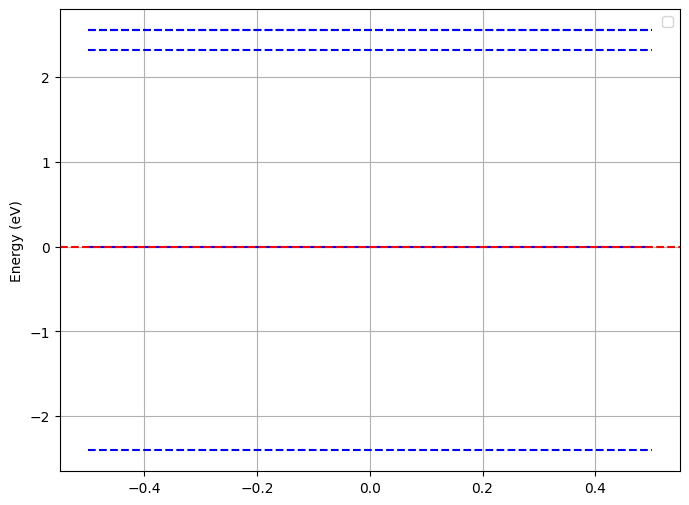

In [15]:
# Diagonalize the Hermitian Hamiltonian using eigh (eigenvalues are automatically sorted)
eigenvalues, eigenvectors = eigh(H_lcao,S_lcao)

homo_energy = eigenvalues[homo_index]
lumo_energy = eigenvalues[lumo_index]

# Calculate the HOMO-LUMO gap
homo_lumo_gap = lumo_energy - homo_energy
dft_gap = homo_lumo_gap
print(f"HOMO energy: {homo_energy} eV")
print(f"LUMO energy: {lumo_energy} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

fermi_level = 0

# Find the index of the state closest to the Fermi level (E_fermi)
fermi_index = np.argmin(np.abs(eigenvalues - fermi_level))

# Define how many states above and below the Fermi level to plot
n_valence = 1
n_conduction = 3

# Select indices for the eigenstates ±n around the Fermi level
start_index = max(fermi_index - n_valence, 0)  # Ensure index does not go below zero
end_index = min(fermi_index + n_conduction + 1, len(eigenvalues))  # Ensure index does not go above the total number of eigenstates
selected_indices = np.arange(start_index, end_index)

# Plot the eigenvalues
plt.figure(figsize=(8, 6))
x_min, x_max = -0.5, 0.5

for idx in selected_indices:
    energy = eigenvalues[idx]
    # Plot a horizontal line at each eigenvalue with finite width along x
    plt.hlines(energy, x_min, x_max, colors='blue', linestyles='--')
plt.axhline(0, color='red', linestyle='--')

plt.ylabel('Energy (eV)')
plt.legend()
plt.grid(True)
plt.show()

### Get Hamiltonian and Overlap matrices in the LO basis and Pick out only C 2pz orbitals 

I know a priori that, of the 13 orbitals of C, index '3' corresponds to C 2pz. This is based on visualizing the LOs cube files. If you are interested in, for example, the 1s orbitals, visualize the cube files for the orbitals and find which index produced a cube file that shows 1s behavior. The following calculation shows how to extract only the C 2pz contributions to the Hamiltonian

In [16]:
# Perform subdiagonalization

nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

SUBDIAG_SPECIES = ("C", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_subdiagonal = rotate_matrix(H_lcao, Usub)
S_subdiagonal = rotate_matrix(S_lcao, Usub)

# Define the active region within the subdiagonalized species (C 2 pz in this case)
active = {'C':[3]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]


for idx in index_active_region:
    if Usub[idx-1,idx] < 0.: # change sign
        Usub[:,idx] *= -1

lowdin = False
if lowdin:
    Ulow = lowdin_rotation(H_subdiagonal, S_subdiagonal, index_active_region)

    H_subdiagonal = rotate_matrix(H_subdiagonal, Ulow)
    S_subdiagonal = rotate_matrix(S_subdiagonal, Ulow)

H_active, S_active = create_active_hamiltonian(H_subdiagonal, S_subdiagonal, index_active_region)

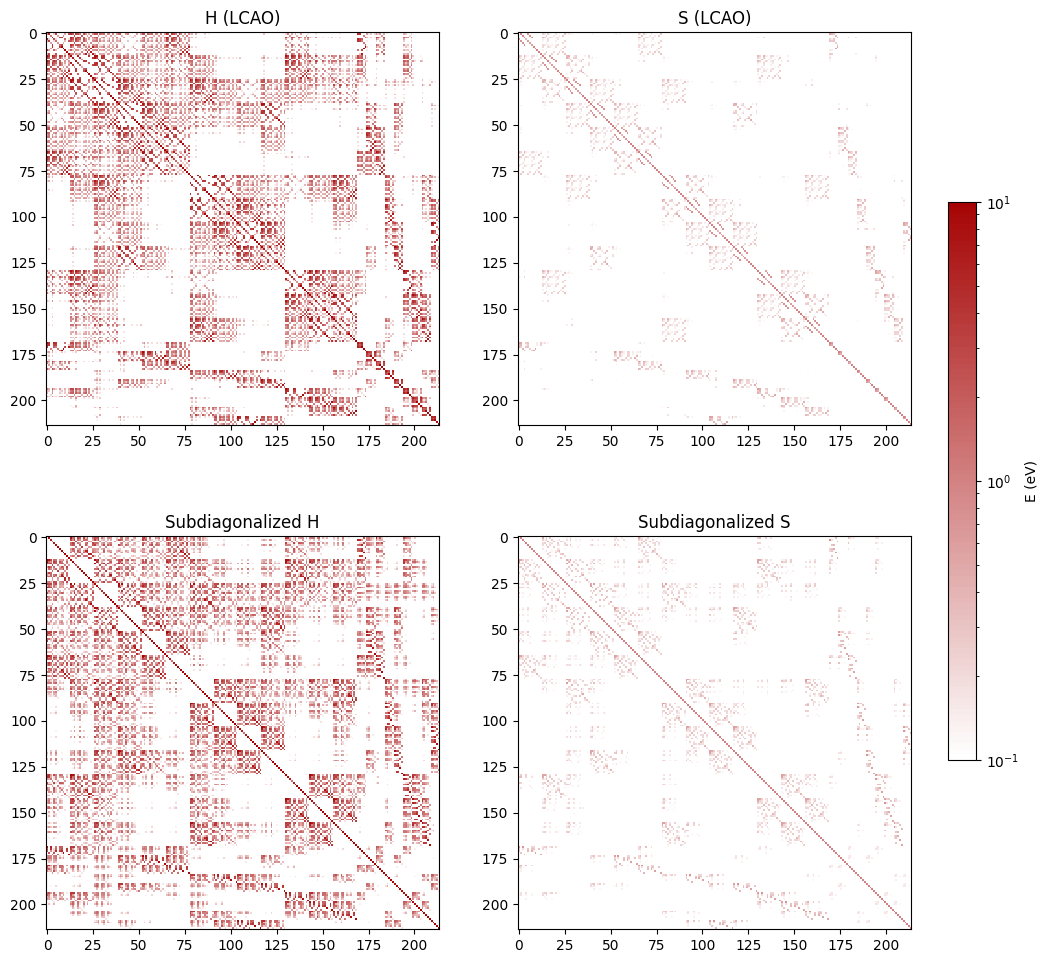

In [17]:
# Note that I'm plotting the absolute values in H and S for ease of visualization.

cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot H_lcao in the first row, first column
cax1 = axs[0, 0].imshow(np.abs(H_lcao), interpolation='nearest', cmap=cm, norm=norm)
axs[0, 0].set_title("H (LCAO)")

# Plot S_lcao in the first row, second column
cax2 = axs[0, 1].imshow(np.abs(S_lcao), interpolation='nearest', cmap=cm, norm=norm)
axs[0, 1].set_title("S (LCAO)")

# Plot H_subdiagonal in the second row, first column
cax3 = axs[1, 0].imshow(np.abs(H_subdiagonal), interpolation='nearest', cmap=cm, norm=norm)
axs[1, 0].set_title("Subdiagonalized H")

# Plot S_subdiagonal in the second row, second column
cax4 = axs[1, 1].imshow(np.abs(S_subdiagonal), interpolation='nearest', cmap=cm, norm=norm)
axs[1, 1].set_title("Subdiagonalized S")

# Add a shared colorbar for all subplots
cbar = fig.colorbar(cax4, ax=axs, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('E (eV)')

plt.show()

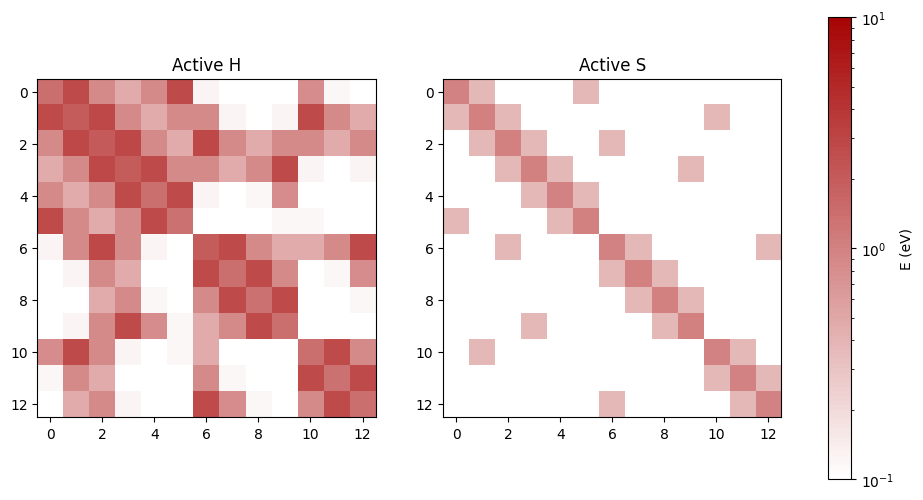

In [18]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized H matrix for the bridge region
cax1 = ax1.imshow(np.abs(H_active), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Active H")

# Plot the subdiagonalized S matrix for the bridge region
cax2 = ax2.imshow(np.abs(S_active), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Active S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HOMO energy: -2.4031397565404498 eV
LUMO energy: 7.100944819275576e-07 eV
HOMO-LUMO gap: 2.4031404666349316 eV


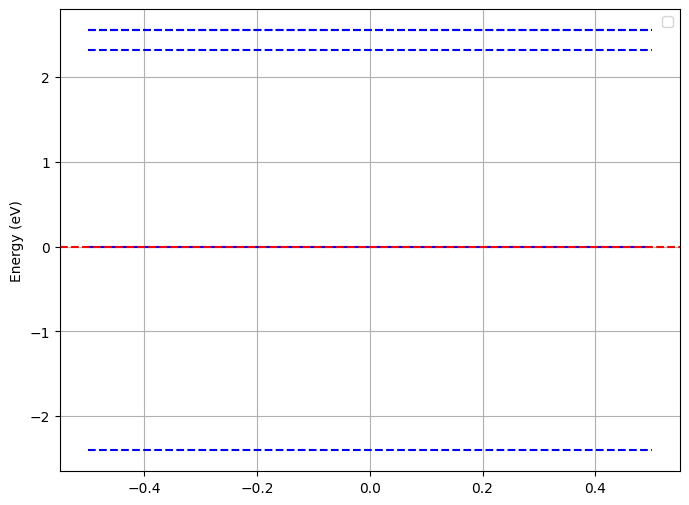

In [19]:
# Diagonalize the Hermitian Hamiltonian using eigh (eigenvalues are automatically sorted)
eigenvalues, eigenvectors = eigh(H_subdiagonal,S_subdiagonal)

homo_energy = eigenvalues[homo_index]
lumo_energy = eigenvalues[lumo_index]

# Calculate the HOMO-LUMO gap
homo_lumo_gap = lumo_energy - homo_energy

print(f"HOMO energy: {homo_energy} eV")
print(f"LUMO energy: {lumo_energy} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

fermi_level = 0

# Find the index of the state closest to the Fermi level (E_fermi)
fermi_index = np.argmin(np.abs(eigenvalues - fermi_level))

# Define how many states above and below the Fermi level to plot
n_valence = 1
n_conduction = 3

# Select indices for the eigenstates ±n around the Fermi level
start_index = max(fermi_index - n_valence, 0)  # Ensure index does not go below zero
end_index = min(fermi_index + n_conduction + 1, len(eigenvalues))  # Ensure index does not go above the total number of eigenstates
selected_indices = np.arange(start_index, end_index)

# Plot the eigenvalues
plt.figure(figsize=(8, 6))
x_min, x_max = -0.5, 0.5

for idx in selected_indices:
    energy = eigenvalues[idx]
    # Plot a horizontal line at each eigenvalue with finite width along x
    plt.hlines(energy, x_min, x_max, colors='blue', linestyles='--')
plt.axhline(0, color='red', linestyle='--')

plt.ylabel('Energy (eV)')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HOMO energy: -2.026923161721295 eV
LUMO energy: 0.23692509847589166 eV
HOMO-LUMO gap: 2.2638482601971868 eV


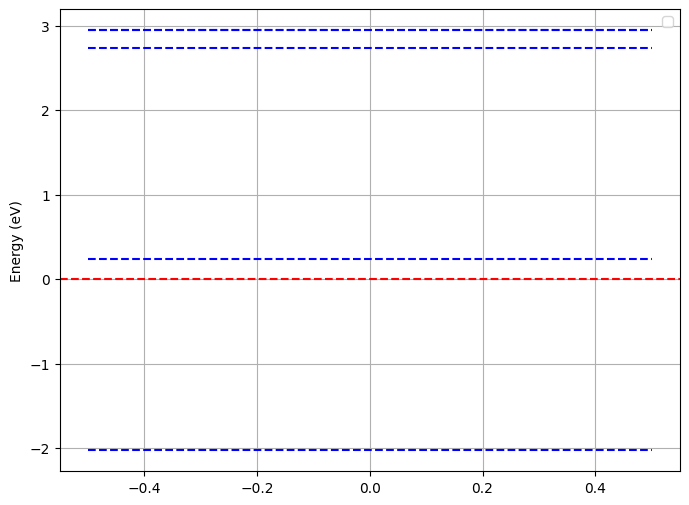

In [20]:
# Diagonalize the Hermitian Hamiltonian using eigh (eigenvalues are automatically sorted)
eigenvalues, eigenvectors = eigh(H_active,S_active)

# Since the H_active has dimensions 26 X 26 and there are 2 electrons per state, 13 states are occupied and 13 are unoccupied.
lumo_index_active = int(np.shape(H_active)[0]/2)
homo_index_active = lumo_index_active - 1

homo_energy = eigenvalues[homo_index_active]
lumo_energy = eigenvalues[lumo_index_active]

# Calculate the HOMO-LUMO gap
homo_lumo_gap = lumo_energy - homo_energy

print(f"HOMO energy: {homo_energy} eV")
print(f"LUMO energy: {lumo_energy} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

fermi_level = 0

# Find the index of the state closest to the Fermi level (E_fermi)
fermi_index = np.argmin(np.abs(eigenvalues - fermi_level))

# Define how many states above and below the Fermi level to plot
n_valence = 1
n_conduction = 3

# Select indices for the eigenstates ±n around the Fermi level
start_index = max(fermi_index - n_valence, 0)  # Ensure index does not go below zero
end_index = min(fermi_index + n_conduction + 1, len(eigenvalues))  # Ensure index does not go above the total number of eigenstates
selected_indices = np.arange(start_index, end_index)

# Plot the eigenvalues
plt.figure(figsize=(8, 6))
x_min, x_max = -0.5, 0.5

for idx in selected_indices:
    energy = eigenvalues[idx]
    # Plot a horizontal line at each eigenvalue with finite width along x
    plt.hlines(energy, x_min, x_max, colors='blue', linestyles='--')
plt.axhline(0, color='red', linestyle='--')


plt.ylabel('Energy (eV)')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
priny

NameError: name 'priny' is not defined

# Lowdin Orthogonalization

In [21]:
lowdin = True
if lowdin:
    Ulow = lowdin_rotation(H_subdiagonal, S_subdiagonal, index_active_region)

    H_subdiagonal_low = rotate_matrix(H_subdiagonal, Ulow)
    S_subdiagonal_low = rotate_matrix(S_subdiagonal, Ulow)
    
H_active_low, S_active_low = create_active_hamiltonian(H_subdiagonal_low, S_subdiagonal_low, index_active_region)

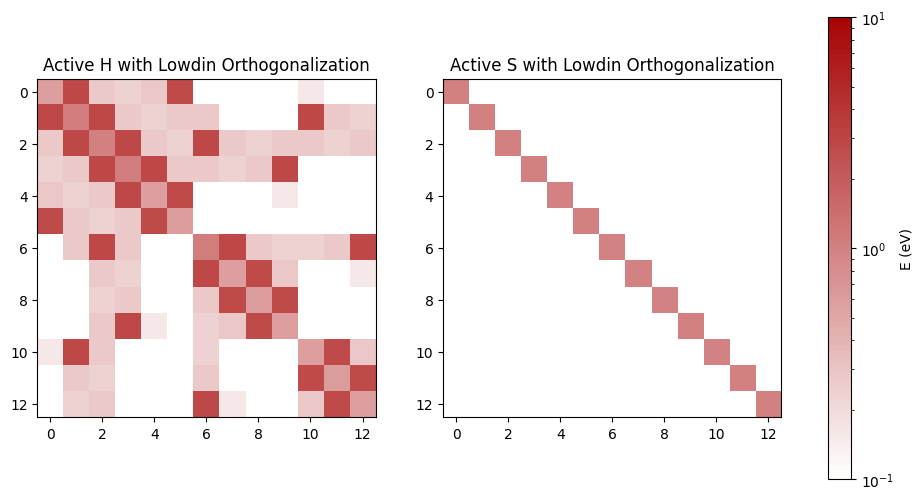

In [23]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized H matrix for the bridge region
cax1 = ax1.imshow(np.abs(H_active_low), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Active H with Lowdin Orthogonalization")

# Plot the subdiagonalized S matrix for the bridge region
cax2 = ax2.imshow(np.abs(S_active_low), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Active S with Lowdin Orthogonalization")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HOMO energy: -2.0269231617212946 eV
LUMO energy: 0.2369250984758926 eV
HOMO-LUMO gap: 2.263848260197187 eV


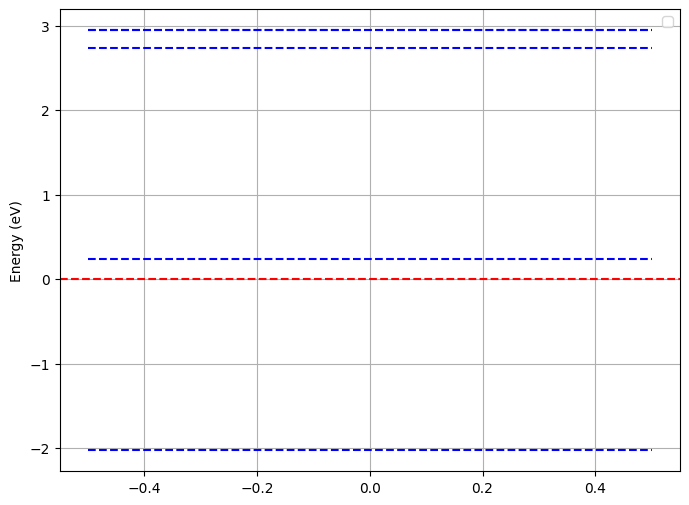

In [24]:
# Diagonalize the Hermitian Hamiltonian using eigh (eigenvalues are automatically sorted)
eigenvalues, eigenvectors = eigh(H_active_low,S_active_low)

# Since the H_active has dimensions 26 X 26 and there are 2 electrons per state, 13 states are occupied and 13 are unoccupied.
lumo_index_active = int(np.shape(H_active_low)[0]/2)
homo_index_active = lumo_index_active - 1

homo_energy = eigenvalues[homo_index_active]
lumo_energy = eigenvalues[lumo_index_active]

# Calculate the HOMO-LUMO gap
homo_lumo_gap = lumo_energy - homo_energy

print(f"HOMO energy: {homo_energy} eV")
print(f"LUMO energy: {lumo_energy} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

fermi_level = 0

# Find the index of the state closest to the Fermi level (E_fermi)
fermi_index = np.argmin(np.abs(eigenvalues - fermi_level))

# Define how many states above and below the Fermi level to plot
n_valence = 1
n_conduction = 3

# Select indices for the eigenstates ±n around the Fermi level
start_index = max(fermi_index - n_valence, 0)  # Ensure index does not go below zero
end_index = min(fermi_index + n_conduction + 1, len(eigenvalues))  # Ensure index does not go above the total number of eigenstates
selected_indices = np.arange(start_index, end_index)

# Plot the eigenvalues
plt.figure(figsize=(8, 6))
x_min, x_max = -0.5, 0.5

for idx in selected_indices:
    energy = eigenvalues[idx]
    # Plot a horizontal line at each eigenvalue with finite width along x
    plt.hlines(energy, x_min, x_max, colors='blue', linestyles='--')
plt.axhline(0, color='red', linestyle='--')


plt.ylabel('Energy (eV)')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
import itertools
import numpy as np
from scipy.linalg import eigh

num_spherical_harmonics_C = 13
num_spherical_harmonics_H = 5
target_gap = dft_gap  # Define your target gap

# Placeholder for the best active region and gap difference
best_active_dict = {}
best_gap_diff = float('inf')

# Iterate over all possible combinations of orbitals for C
for num_C_orbitals in range(1, num_spherical_harmonics_C + 1):
    for combination in itertools.combinations(range(num_spherical_harmonics_C), num_C_orbitals):
        # Define the active space dictionary for this iteration
        active = {'C': list(combination)}

        # Extract the active region and index it
        extract_active_region = basis_subdiag_region.extract().take(active)
        index_active_region = index_subdiag_region[extract_active_region]

        # Apply Lowdin rotation if required
        if lowdin:
            Ulow = lowdin_rotation(H_subdiagonal, S_subdiagonal, index_active_region)
            H_subdiagonal = rotate_matrix(H_subdiagonal, Ulow)
            S_subdiagonal = rotate_matrix(S_subdiagonal, Ulow)

        # Create the active Hamiltonian and overlap matrices
        H_active, S_active = create_active_hamiltonian(H_subdiagonal, S_subdiagonal, index_active_region)

        # Diagonalize the Hamiltonian
        eigenvalues, eigenvectors = eigh(H_active, S_active)

        # Calculate the HOMO and LUMO energies
        lumo_index_active = int(np.shape(H_active)[0] / 2)
        homo_index_active = lumo_index_active - 1

        homo_energy = eigenvalues[homo_index_active]
        lumo_energy = eigenvalues[lumo_index_active]

        # Calculate the HOMO-LUMO gap
        homo_lumo_gap = lumo_energy - homo_energy

        # Check if this gap is the closest to the target gap
        gap_diff = abs(homo_lumo_gap - target_gap)
        if gap_diff < best_gap_diff:
            best_gap_diff = gap_diff
            best_active_dict = active
            best_homo_lumo_gap = homo_lumo_gap

print("\nBest active space found:")
print(f"Active space: {best_active_dict}")
print(f"Closest HOMO-LUMO gap: {best_homo_lumo_gap:.6f} eV")
print(f"Difference from target gap: {best_gap_diff:.6f} eV")



Best active space found:
Active space: {'C': [0, 4, 6, 8, 9, 10, 12]}
Closest HOMO-LUMO gap: 2.406131 eV
Difference from target gap: 0.002991 eV


In [68]:
import itertools
import numpy as np
from scipy.linalg import eigh

num_spherical_harmonics_H = 5
target_gap = dft_gap  # Define your target gap

# Placeholder for the best active region and gap difference
best_active_dict = {}
best_gap_diff = float('inf')

# Fix the active space for C
active_C = list(range(13))
active_H = list(range(5))

# Iterate over all possible combinations of orbitals for H
for num_H_orbitals in range(1, num_spherical_harmonics_H + 1):
    for combination_H in itertools.combinations(range(num_spherical_harmonics_H), num_H_orbitals):
        
        # Define the active space dictionary with fixed 'C': [3]
        active = {'C': active_C, 'H':active_H}#list(combination_H)}

        # Extract the active region and index it
        extract_active_region = basis_subdiag_region.extract().take(active)
        index_active_region = index_subdiag_region[extract_active_region]

        # Apply Lowdin rotation if required
        if lowdin:
            Ulow = lowdin_rotation(H_subdiagonal, S_subdiagonal, index_active_region)
            H_subdiagonal = rotate_matrix(H_subdiagonal, Ulow)
            S_subdiagonal = rotate_matrix(S_subdiagonal, Ulow)

        # Create the active Hamiltonian and overlap matrices
        H_active, S_active = create_active_hamiltonian(H_subdiagonal, S_subdiagonal, index_active_region)

        # Diagonalize the Hamiltonian
        eigenvalues, eigenvectors = eigh(H_active, S_active)

        # Calculate the HOMO and LUMO energies
        lumo_index_active = int(np.shape(H_active)[0] / 2)
        homo_index_active = lumo_index_active - 1

        homo_energy = eigenvalues[homo_index_active]
        lumo_energy = eigenvalues[lumo_index_active]

        # Calculate the HOMO-LUMO gap
        homo_lumo_gap = lumo_energy - homo_energy

        # Check if this gap is the closest to the target gap
        gap_diff = abs(homo_lumo_gap - target_gap)
        if gap_diff < best_gap_diff:
            best_gap_diff = gap_diff
            best_active_dict = active
            best_homo_lumo_gap = homo_lumo_gap

print("\nBest active space found:")
print(f"Active space: {best_active_dict}")
print(f"Closest HOMO-LUMO gap: {best_homo_lumo_gap:.6f} eV")
print(f"Difference from target gap: {best_gap_diff:.6f} eV")



Best active space found:
Active space: {'C': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'H': [0, 1, 2, 3, 4]}
Closest HOMO-LUMO gap: 0.130220 eV
Difference from target gap: 2.272920 eV
